# Exploratory Data Analysis

## Imports

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import string
import nltk
from nltk.corpus import stopwords
import sys
import os
import re

# Add the root project directory to the Python path
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.data_loader import load_raw_data #importing data loader

# Setup
sns.set(style = "whitegrid")
nltk.download("stopwords")


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenny\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
print(os.getcwd())

c:\Users\Lenny\Downloads\movie-review-sentiment-analysis\notebooks


## Loading the dataset

In [4]:
# Load the dataset
text_df = load_raw_data()

# Preview
text_df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## EDA

### General Overview

Dataset shape: (50000, 2)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


<Axes: title={'center': 'Class Balance'}, xlabel='sentiment'>

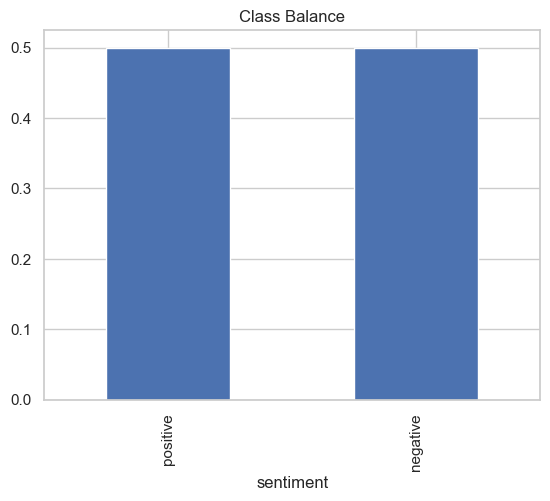

In [5]:
# Basic info
print(f"Dataset shape: {text_df.shape}")
print(text_df.info())
text_df["sentiment"].value_counts(normalize=True).plot(kind="bar", title="Class Balance")

This is a balanced dataset with no missing values. 

       review_length
count   50000.000000
mean      231.156940
std       171.343997
min         4.000000
25%       126.000000
50%       173.000000
75%       280.000000
max      2470.000000


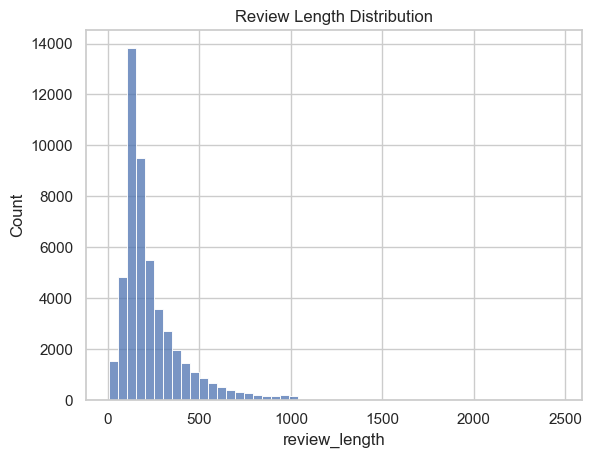

In [6]:
# Adding a column for review length
text_df["review_length"] = text_df["review"].apply(lambda x: len(str(x).split()))
sns.histplot(text_df["review_length"], bins=50)
plt.title("Review Length Distribution")
print(text_df.describe())

In [7]:
# checking for duplicates
text_df.nunique()

review           49582
sentiment            2
review_length     1047
dtype: int64

### Data Integrity Checks

In [8]:
text_df.isnull().sum()

review           0
sentiment        0
review_length    0
dtype: int64

In [31]:
text_df["review"].duplicated().sum()

np.int64(418)

Duplicates need to be dropped at some point

In [10]:
text_df[text_df.duplicated() == True]

,review,sentiment,review_length
3537,Quite what the producers of this appalling ada...,negative,401
3769,My favourite police series of all time turns t...,positive,94
4391,"Beautiful film, pure Cassavetes style. Gena Ro...",positive,110
6352,If you liked the Grinch movie... go watch that...,negative,100
6479,I want very much to believe that the above quo...,negative,446
...,...,...,...
49912,This is an incredible piece of drama and power...,positive,170
49950,This was a very brief episode that appeared in...,negative,199
49984,Hello it is I Derrick Cannon and I welcome you...,negative,417
49986,This movie is a disgrace to the Major League F...,negative,118


In [36]:
text_df_no_duplicates = text_df.drop_duplicates(subset = ["review"],
                                                keep="first")
text_df_no_duplicates.shape

(49582, 3)

### Numeric Features

C:\Users\Lenny\AppData\Local\Temp\ipykernel_29672\469294758.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


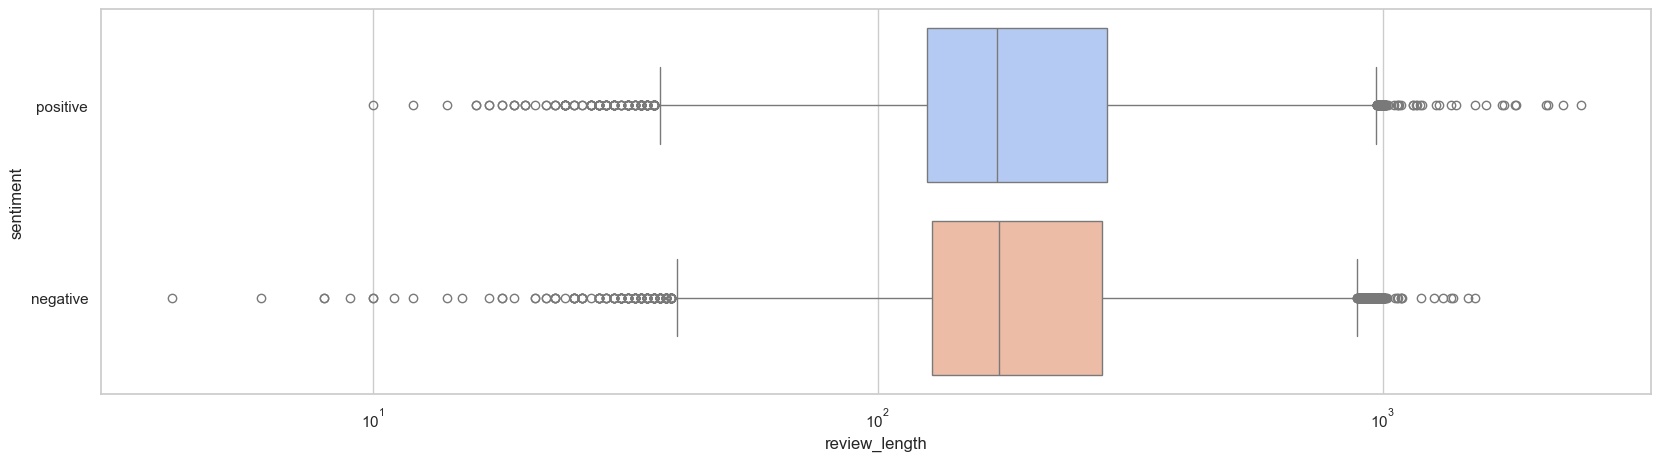

In [38]:
plt.figure(figsize = (20,5))
sns.boxplot(
    data = text_df_no_duplicates,
    x = text_df["review_length"],
    y = text_df["sentiment"],
    palette = "coolwarm",
    log_scale = True
)
plt.show()

### Text features

In [41]:
text_df_no_duplicates.iloc[0, 0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

text has html tags

In [52]:
# removing html tags
s = text_df_no_duplicates.iloc[0, 0]
regex = r"<.*?>|[^\x00-\x7F]|http\S+|www\S+"
print(re.sub(regex, "", s))

One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.I would say the main appeal of the show is due to the fact that it goes where other shows wou

In [51]:
# adding clean review column
text_df_no_duplicates["clean_review"] = text_df_no_duplicates["review"].apply(lambda x: re.sub(regex, "", x))

C:\Users\Lenny\AppData\Local\Temp\ipykernel_29672\3999398783.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  text_df_no_duplicates["clean_review"] = text_df_no_duplicates["review"].apply(lambda x: re.sub(regex, "", x))
